# Project 2 Workbook

## Business Problem

* For the first part of the project, you will try to determine what affects housing prices using **exploratory data analysis, hypothesis tests, and linear regression**. 


* The goal of this analysis is to be able to come away with valuable insights regarding home prices. 


* Imagine a real estate agent comes to you and asks for information about the housing market in Kings County.
 * What would your analysis tell them that would be helpful to them as they help clients buy and sell houses?


* *Imagine homeowners from Kings County want to increase the resale value of their home.*
     * They are willing to spend some money on renovations

- **Exploratory Data Analysis (EDA):** You must create **at least 4 data visualizations** that help to explain the data. These visualizations should help someone unfamiliar with the data understand the target variable and the features that help explain that target variable.

- **Feature Engineering:** You must create **at least 3 new features** that you think will are related to the price of a house. In the notebook you you need to explain the features you engineer and your thought process behind why you created them.  

- **Statistical Tests:** Your notebook must show **at least 3 statistical tests** that you preformed on your data set. Think of these as being part of your EDA process; for example, if you think houses with a view cost more than those without a view, then perform a two-sample T-test. These willpreliminary evidence that a feature will be important in your model.  

- **Linear Regression Model:** One of the benefits of a linear regression model is that you can **interpret the coefficients** of the model **to derive insights**. For example, which feature has the biggest impact on the price of the house? Was there a feature that you thought would be significant but was not once other features were considered?  Models for inference are typically simpler so they are more straight forward to interpret, so you probably won't include all of your features in this model. 

## PROCESS CHECKLIST


> Keep in mind that it is normal to jump between the OSEMN phases and some of them will blend together, like SCRUB and EXPLORE.

1. **[OBTAIN](#OBTAIN)**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>


2. **[SCRUB](#SCRUB)**
    - Recast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ] Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
            
    - [ ] Check for missing values` (df.isna().sum())`
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
    
3. **[EXPLORE](#EXPLORE)**
    - [ ] Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
   
4. **[MODEL](#MODEL)**

    - **Fit an initial model:** 
        - Run an initial model and get results

    - **Holdout validation / Train/test split**
        - use sklearn `train_test_split`
    
    
5. **[iNTERPRET](#iNTERPRET)**
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
    - **Revise the fitted model**
        - Multicollinearity is big issue for lin regression and cannot fully remove it
        - Use the predictive ability of model to test it (like R2 and RMSE)
        - Check for missed non-linearity
        
       
6. **Interpret final model and draw >=3 conclusions and recommendations from dataset**

## Imports

In [221]:
# Data Handling
import pandas as pd
import numpy as np
from scipy import stats
import json
import plotly.express as px

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sms

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV

# Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)

## Defining Functions

### Data Cleaning

> The following functions enable the user to filter a Pandas series and return a boolean index to use for filtering out the outliers.
>
> In order to use the functions effectively, the results must be saved to a new variable. Then the user can perform further filtering by using the new variable to slice the dataframe to be filtered.

#### ƒ: `find_outliers_z`

In [84]:
## Check using z-score - sensitive to outliers

def find_outliers_z(data):
    """Detects outliers using the Z-score>3 cutoff.
    Returns a boolean Series where True=outlier
    
    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    zFP = np.abs(stats.zscore(data))
    zFP = pd.Series(zFP, index=data.index)
    idx_outliers = zFP > 3
    return idx_outliers

#### ƒ: `find_outliers_IQR`

In [85]:
## Check using IQR - less sensitive to outliers

def find_outliers_IQR(data):
    """
    * Takes a series sliced from a dataframe
    * Detects outliers using the 1.5*IQR thresholds.
    * Returns a boolean Series where True=outlier

    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    res = data.describe()
    q1 = res['25%']
    q3 = res['75%']
    thresh = 1.5*(q3-q1)
    idx_outliers =(data < (q1-thresh)) | (data > (q3+thresh))
    return idx_outliers

##### Testing Functions

In [86]:
# ## Testing Z-Score method

# # Run function
# idx_bdrm_out_z = find_outliers_z(df['bedrooms'])

# # Save non-outliers as new variable 
# df_bdrm_clean_z = df[~idx_bdrm_out_z].copy()

# # Print total number of outliers from data
# print(f'There were {idx_bdrm_out.sum()} outliers.')

# # Show final data
# df_bdrm_clean

In [87]:
# # Testing IQR method

# # Run function
# idx_bdrm_out_iqr = find_outliers_IQR(df['bedrooms'])

# # Save non-outliers as new variable 
# df_bdrm_clean_iqr = df[~idx_bdrm_out_iqr].copy()

# # Print total number of outliers from data
# print(f'There were {idx_bdrm_out_iqr.sum()} outliers.')

# # Show final data
# df_bdrm_clean_iqr

### Creating new functions for cleaning and visualizations

#### ƒ: `feature_vis`

In [88]:
def feature_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    * Requires a DataFrame and a column name to process.
    * Keyword arguments specify that the target variable will be "price"
    for this case.
    * For future use, redefine function without predetermined y-value, or 
    reassign.
    
    --
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    
    * Kwargs:
        * y = "price"
        * discrete = False
        * kde = true
        
    -----'''
    
    ## Print the slice of the original DataFrame for easy viewing
    
    print(df[x].value_counts().sort_index())
  
    ## Create two plots via Seaborn: one scatter plot with regression line,
    ## then a histogram of the data (with KDE if specified
    
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=data, x=x, y=y, ax=axs[0])
    sns.histplot(data=data, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return

#### ƒ: `filter_outliers`

In [89]:
def filter_outliers(data):
    '''------
    
    * Removes outliers from data via "find_outliers_IQR" and saves filtered
    values to the dataframe
    
    ---
    
    * Arg:
        * Data: slice of a dataframe for a specific column header
    
    ------
    '''
   
    idx_out = find_outliers_IQR(data)
 
    cleaned = df[~idx_out]

    print(f'There were {idx_out.sum()} outliers.')
    
    return cleaned

#### ƒ: `remove_outliers`

In [90]:
def remove_outliers(data, x):

    idx_out = find_outliers_IQR(data[x])
 
    df_clean = df[~idx_out].copy()
    
    return df_clean

#### ƒ: `show_cleaned_vis`

In [91]:
def show_cleaned_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    
    * Combines functions to filter outliers and to create the feature 
        visualizations.
    * Requres 'find_outliers_IQR' and 'feature_vis' to be defined.
    * Returns filtered data and two visualizations - Seaborn regression plot
        and histplot.
    
    ---
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    * Kwargs
    
    -----'''
    
    ### Filter outliers first
    
    idx_out = find_outliers_IQR(data[x])
 
    df_cleaned = df[~idx_out].copy()

    print(f'There were {idx_out.sum()} outliers.')
    
    ### Plot Data
    
    
    df_cleaned[x].value_counts().sort_index()
        
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=df_cleaned, x=x, y=y, ax=axs[0])
    sns.histplot(data=df_cleaned, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return #df_cleaned

### Creating Function for T-Testing

#### ƒ: `ttest_review`

In [92]:
def ttest_review(sample_1, sample_2, alpha=.05):
    '''------
    * Runs a t-test on two samples; prints whether or not they are significant,
    and returns p-value as a variable called "p-value."
    * Requires two data samples and an alpha value.
    
    ----
    
    * Args: two data samples for t-test
    * Kwargs: alpha=.05
    
    -----
    '''
    
    result = stats.ttest_ind(sample_1, sample_2)
    crit_val, p_val = result
    
    ## Creating interpretation based on p-value results.

    if p_value < .05:
        print(f'The feature "waterfront" is statistically significant with a p-value of {p_val}.')

    else:
         print(f'The feature "waterfront" is not statistically significant with a p-value of {p_val}.')
    
    return p_val

### Creating Correlation Matrix

#### ƒ: `"corr_val"`

In [93]:
# Create "corr_val" function

def corr_val(df,figsize=(15,15),cmap="OrRd",):
    
    # Calculate correlations
    corr = df.corr()
       
    # Create a mask of the same size as our correlation data
    mask = np.zeros_like(corr)
    
    # Set the upper values of the numpy array to "True" to ignore them
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    
    # Mask=mask to hide the upper-right half of values (otherwise mirrored)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax

### Creating and Evaluating Models

#### ƒ: `create_model`

In [94]:
def create_model(data, cont, cat):
    '''------
    
    * Creates a linear regression model using Statsmodels OLS
    * Save the 
    
    ---
    
    * Args:
        * Data: dataframe as data source
        * Cont: list of continuous variables
        * Cat: list of categorical variables
        * unique_id: UNIQUE name for the resulting model
    
    -----
    '''

    cont_features = '+'.join(cont)

    cat_features = '+'.join([f'C({x})' for x in cat])

    f = f'price~+{cont_features}+{cat_features}'

    print(f)

    model = smf.ols(formula=f, data=data).fit()
   
    diagnose_model(model)
    
    return model

#### ƒ: `diagnose_model`

>* Create a function to:
>  * Display the summary details of the model
>  * Create a scatter plot of the predictions
>    * Used for determining homoscedasticity
>  * Create a Q-Q plot of the residuals of the model
>    * Used to determine the normality of the residuals


In [95]:
def diagnose_model(model, figsize=(10,5)):
    """ ---
    
    Argument:
        * model: provide the linear regression model for diagnostics
    
    Keyword Argument:
        * figsize: default (10,5); can increase/decrease for larger/smaller
    ---
    
    * Display the summary details of the provided model
    * Create two scatter plots to test assumptions of linearity
        * Predictions: verifying homoscedasticity (no cone-shapes)
        * Residuals: confirming normal distribution of residuals
    ---
    
    """
    display(model.summary())
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    axes[0].scatter(model.predict(), model.resid)
    axes[0].axhline()
    axes[0].set_xlabel('Model Predictions')
    axes[0].set_ylabel('Model Residuals')
    axes[0].set_title('Testing for Homoscedasticity')

    sms.graphics.qqplot(data=model.resid, fit=True, line = "45", ax=axes[1])
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_param_coef`

>* Create a function to:
>  * Get the model's coefficients as a series
>  * Plot a figure to show the coefficients in descending order


In [96]:
def plot_param_coef(model, kind = 'barh', figsize = (10,5)):
    ''' ---
    
    * Plotting a figure to visualize parameter coefficients
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default (10,10)): allows for different sizes
    ---
    
    '''
    # Plotting figure to visualize parameter coefficients

    ## Getting coefficients as a Series
    params = model.params[1:]
    params.sort_values(inplace=True)

    plt.figure(figsize=figsize) # Used if large number of params
    ax = params.plot(kind=kind)
    ax.axvline()
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Features')
    ax.set_title('Comparing Feature Coefficients')
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_p_values`

>* Create a function to:
>  * Get the model's p-values as a series
>  * Plot a figure to show the p-values in descending order

In [97]:
def plot_p_values(model, kind = 'barh', size = None, alpha = .05):
    ''' ---
    
    * Plots a figure to visualize parameter p-values exceeding stated alpha.
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default None): allows for different sizes
    ---
    
    '''
    
    pv = model.pvalues[1:]
    pv_high = pv[pv > alpha]
    pv_low = pv[pv <= alpha]
    pv_high.sort_values(ascending=False, inplace=True)
    
    if len(pv_high) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_high.plot(kind=kind)
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values')
        
    if len(pv_low) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values Below {alpha}')        
        
#     else:
#         print(f'There are no p-values above {alpha}.')
        
    plt.tight_layout()
    
    return

#### ƒ: `review_model` (Combined)

In [98]:
def review_model(model):
    '''---
    
    Combines earlier functions into one all-purpose function for reviewing
    model performance.
    
    ---
    
    Arg:
        * model: Specify model to review.
        
    ---'''
    
    diagnose_model(model)
    
    plot_param_coef(model)
    
    plot_p_values(model)
    
    return    

## Reading Data

In [99]:
df= pd.read_csv('kc_house_data_train.csv', index_col=0)

# Exploring Fresh Data

## Basic Overviews

In [100]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

**DF Columns to Convert**

* 'date' obj -> datetime; may drop

In [102]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

> No null values to worry about. Next, I will inspect each column to explore features

In [103]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


## Exploring Features

> **The "feature_vis" function is designed to take a given feature as an argument, then return the raw values and two plots.** The first plot is a scatter plot with regression line, and the second plot is a histogram (with/out KDE plot overlaid if specified when running function).**
>
> **The benefit of this function** is that we are able to identify categorical vs. continuous variables and get an estimation of the relationship between the variable and our dependent variable, "Price."

### Bedrooms

There were 451 outliers.


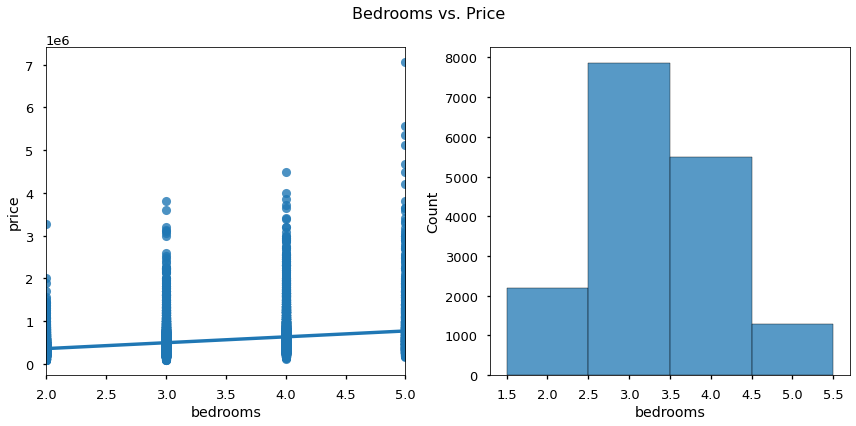

In [104]:
show_cleaned_vis(df,"bedrooms", discrete=True, kde = False)

In [105]:
remove_outliers(df, 'bedrooms')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028


***
**Observations**

>* Odd: 0 or 33 bedrooms
>* Box Plot tells us that the high outliers would include anything above 5 bedrooms.
>  * We know that we want to include some of those, though.
>* Somewhat linear relationship until about 6 bedrooms - initial best-fit line has stronger slope at max 5 bedrooms
***
**TO-DO**

>* Identify and remove outliers
>* Use Bedrooms as numerical
***

### Bathrooms

There were 209 outliers.


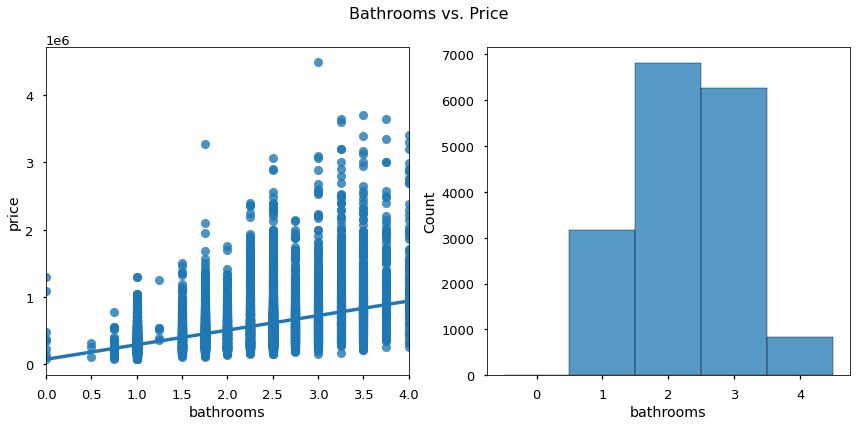

In [106]:
show_cleaned_vis(df,"bathrooms", discrete=True, kde=False)

***
**Observations**

>* Some outliers may be throwing off the counts
>* Somewhat linear relationship
>* Zero bathrooms??

***
**TO-DO**

>* Investigate outliers - 0/7+ bathrooms, higher prices
>* Create box plot to get clearer idea of outliers
*** 

### sqft_living

There were 454 outliers.


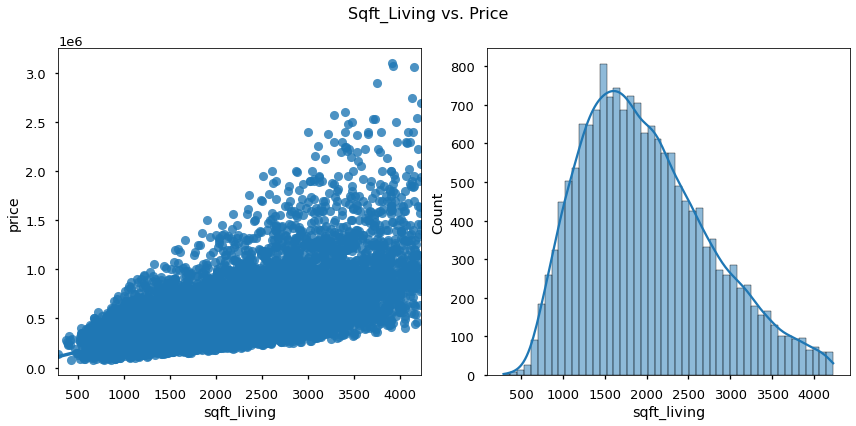

In [107]:
show_cleaned_vis(df,"sqft_living")

***
**Observations**

>* Check outliers - throwing off graphs
>* Positive correlation, seems linear
>* Most seem to be about 2k sq. ft.

***
**TO-DO**

>* Check outliers
>* Use as continuous variable
***

### sqft_lot

There were 1963 outliers.


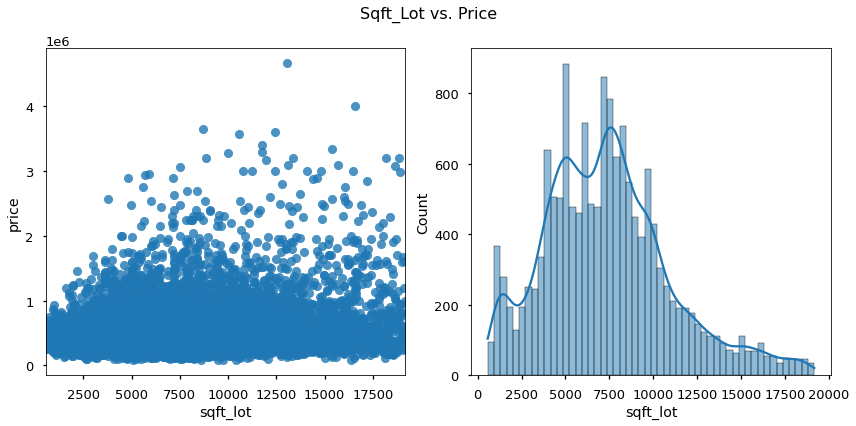

In [108]:
show_cleaned_vis(df,"sqft_lot")

***
**Observations**

>* **Significant** outliers throwing off the numbers considerably.
>* May be normally distributed

***

**TO-DO**

>* Correct outliers
>* run .describe()

* **

### floors

There were 0 outliers.


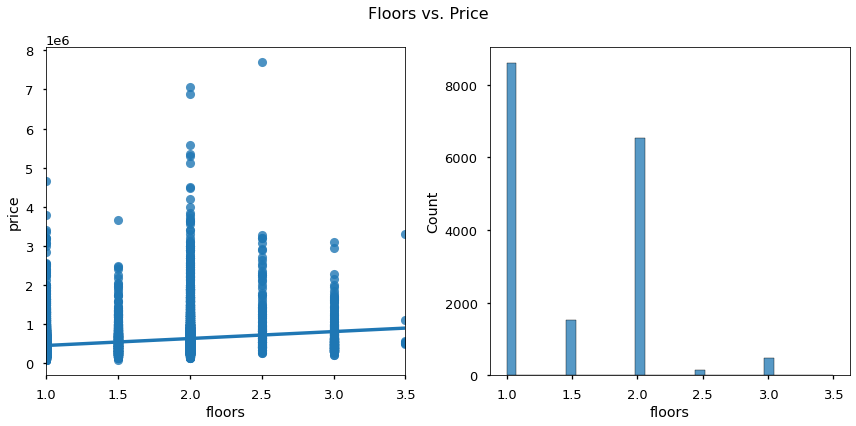

In [109]:
show_cleaned_vis(df,"floors", kde=False)

***
**Observations**

>* Few outliers
>* 1.5, 2.5 floors?
>* Mostly 1 or 2

***
**TO-DO**

>* Outliers
>* Investigate .5 floors
 
***

### waterfront

0    17152
1      138
Name: waterfront, dtype: int64


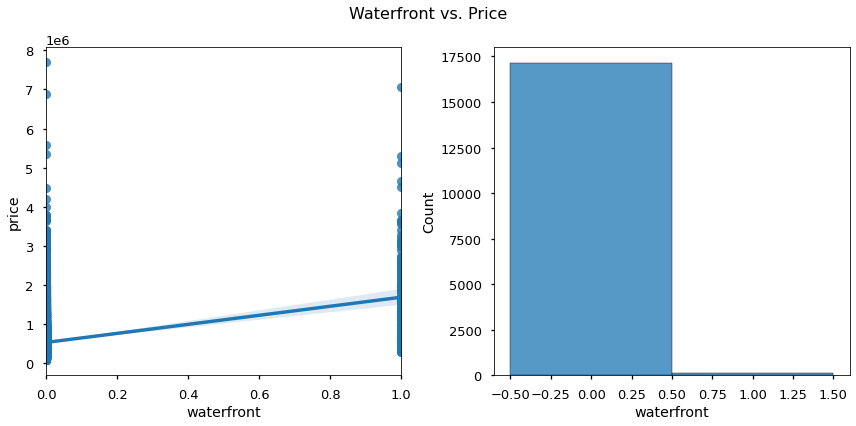

In [110]:
feature_vis(df,"waterfront", discrete=True, kde=False)

***
**Observations**

>* Graphs are misleading
>* Most properties are non-waterfront
>* Looks like price increases with waterfront feature

***
**TO-DO**

>* Change graphs
>* Check the few outliers
>* 
 
***

### view

0    15571
1      264
2      775
3      410
4      270
Name: view, dtype: int64


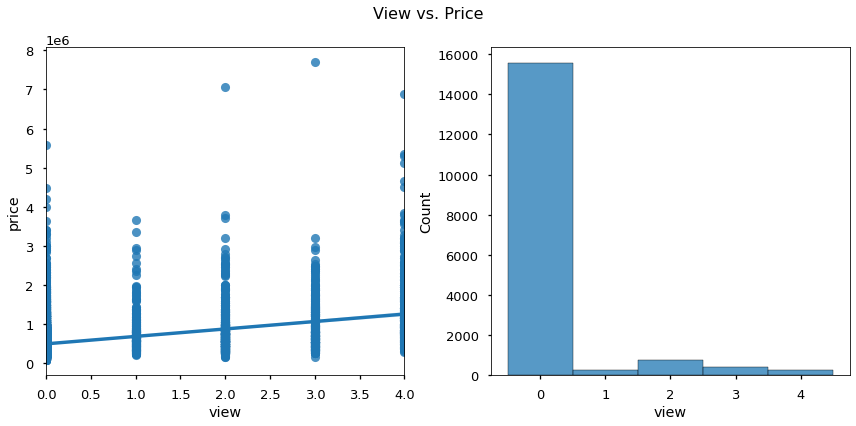

In [111]:
feature_vis(df,"view", discrete=True, kde=False)

***
**Observations**

>* Higher "view" rating, higher price
>* Most have '0' view
>* A few extreme outliers in pricing

***
**TO-DO**

>* Check outliers 
>* Treat as categorical
>* 
 
***

### condition

There were 24 outliers.


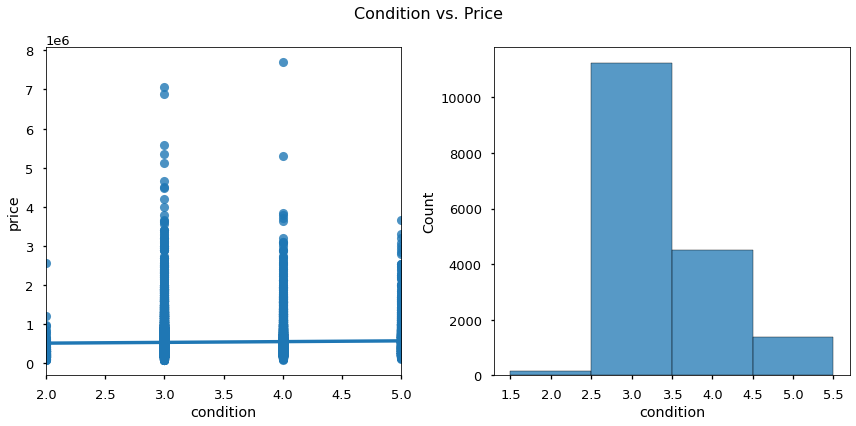

In [112]:
show_cleaned_vis(df,"condition", discrete=True, kde= False)

***
**Observations**

>* Largest number of homes sold were in condition 3
>* Very few sold in 1s, 2s
>* Price outliers in 4.0 area, some slight outliers in 2 and 3

***
**TO-DO**

>* Treat as categorical
>* Investigate outliers
>*
 
***

### grade

There were 1512 outliers.


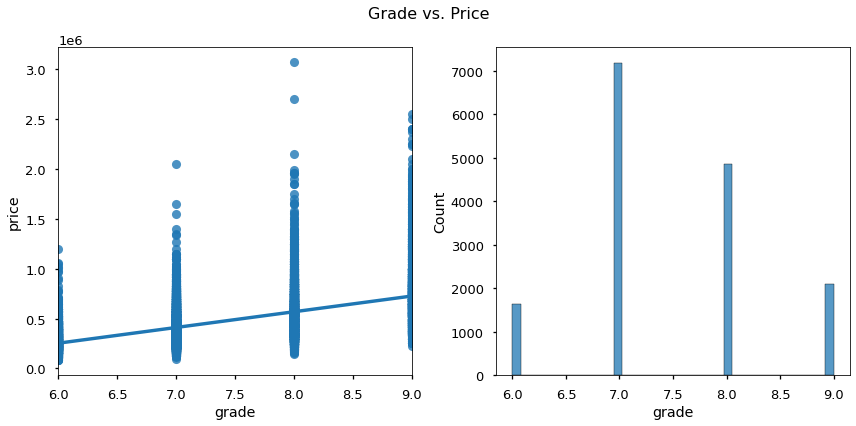

In [113]:
show_cleaned_vis(df,"grade", kde=False)

**Observations**

* Clear linear trend - as grade increases, so does price


* Largest range of grades is 6-9


* Grade 13 - very few houses sold; worth investigating


**TO-DO**

* Investigate grade 13 houses


* Outliers: >= 4, one at 11


* Continuous variable

### sqft_above

There were 498 outliers.


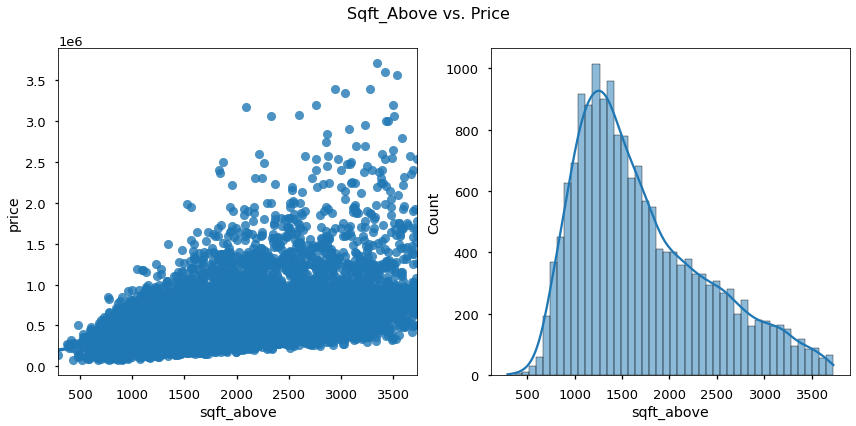

In [114]:
show_cleaned_vis(df,"sqft_above")

**Observations**

* Outliers impacting accuracy of linear regression


* Dist. skewed left


* 


**TO-DO**

* Outliers


* Continuous


*  

### sqft_basement

There were 396 outliers.


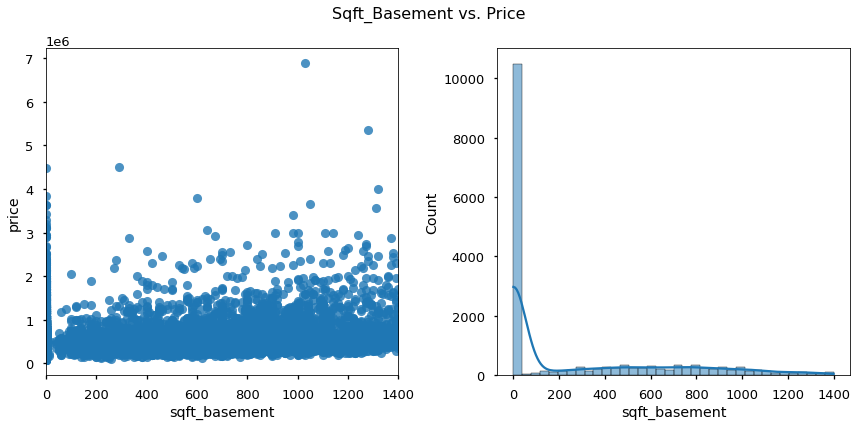

In [115]:
show_cleaned_vis(df,"sqft_basement")

**Observations**

* Lots of 0 SQFT basements - no basement at all on property


* scattered outliers; poor regression due to outliers and 0s


* some extreme outliers


**TO-DO**

* investigate high outliers for basement sizes


* for modeling, ignore 0 SQFT


*  

### yr_built

There were 0 outliers.


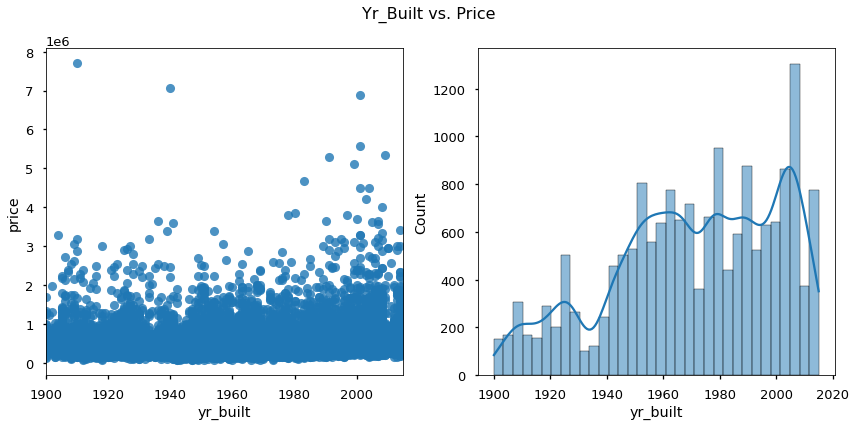

In [116]:
show_cleaned_vis(df,"yr_built")

**Observations**

* No clear trend from this scatterplot


* Seems like may houses built between 1940 - 1970, then major boom in early 2000s.


* Some significant outliers with price


**TO-DO**

* Change regression line for scatter plot to distinguish the relationship


* outliers


* Compare to year sold - how old was the house at sale?

### yr_renovated

0       16564
1934        1
1940        2
1944        1
1945        3
        ...  
2011        8
2012        9
2013       30
2014       71
2015       12
Name: yr_renovated, Length: 69, dtype: int64


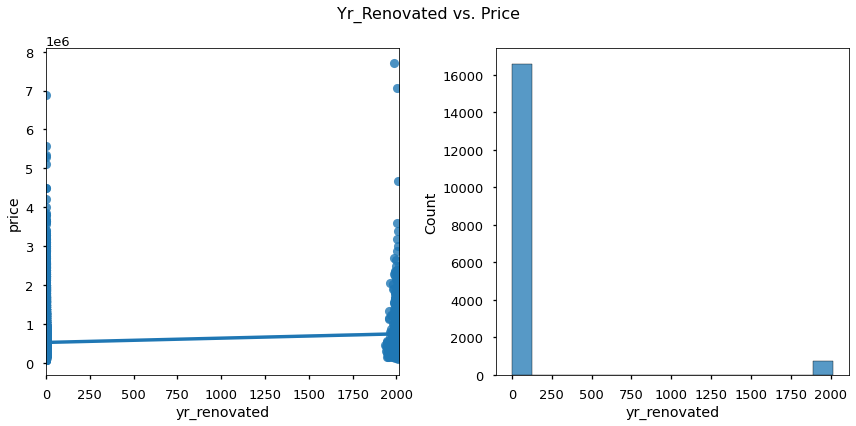

In [117]:
feature_vis(df,'yr_renovated', kde=False)

**Observations**

* Number of houses not renovated significantly outweighs the number renovated


* Graphs would be improved if we look only at the ones that were renovated (i.e. create new feature to distinguish reno vs. non-reno, then remake graphs


* 


**TO-DO**

* Feat Eng: reno/not reno; compare price to y/no


* Significantly high outliers on reno properties


* Convert to categorical, then use conditions to filter for more accuracy

### zipcode

There were 0 outliers.


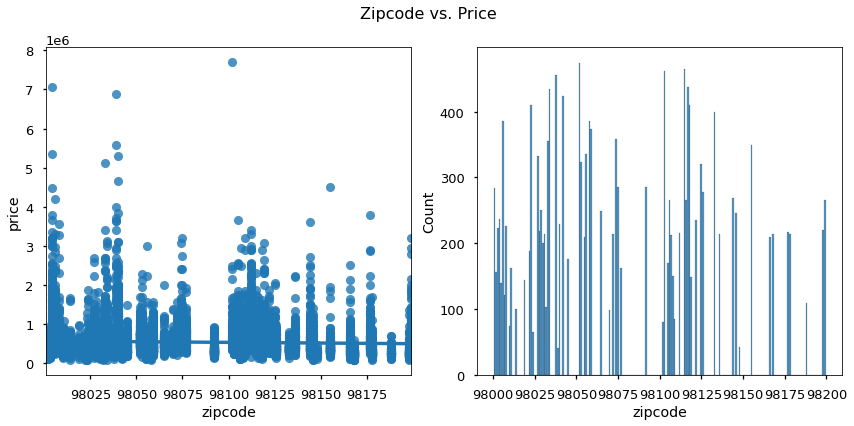

In [118]:
show_cleaned_vis(df,"zipcode", discrete=True, kde=False)

**Observations**

* No linear relationship


* 


* 


**TO-DO**

* Investigate pricing per zip code


* Create grouping based on zip code (groupby) for further analysis


*  

### lat

There were 1 outliers.


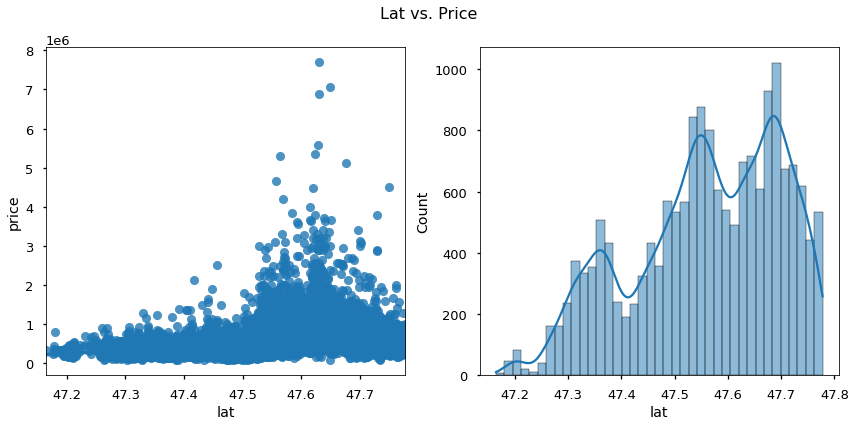

In [119]:
show_cleaned_vis(df,"lat")

**Observations**

* most sold b/t 47.6 and 47.7


* 


* 


**TO-DO**

* compare # houses sold vs lat/long


* geospatial visuals


* FE: distance to major PoIs

### long

There were 206 outliers.


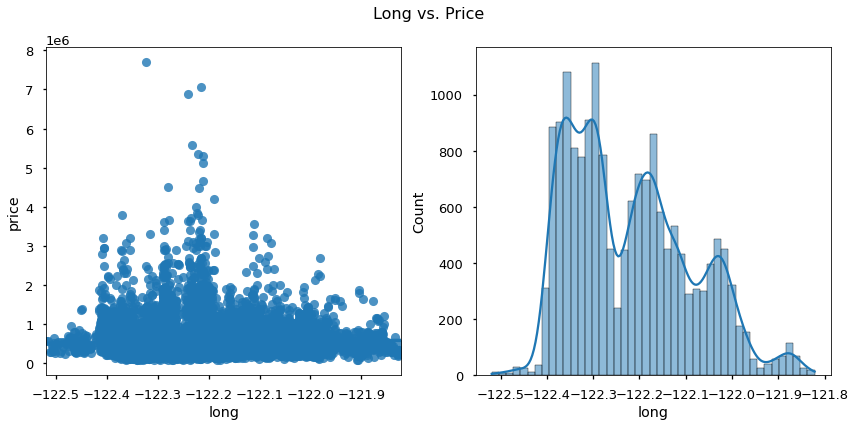

In [120]:
show_cleaned_vis(df,"long")

**Observations**

* See above


* 


* 


**TO-DO**

* 


* 


*  

### sqft_living15

There were 438 outliers.


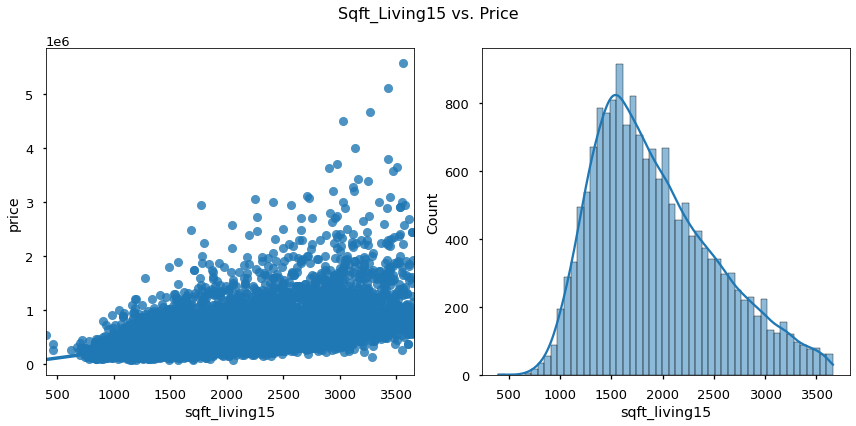

In [121]:
show_cleaned_vis(df,"sqft_living15")

**Observations**

* Most properties sold w/ sqft b/t 1500/2000 


* Price follows linear trend


* 


**TO-DO**

* Price outliers


* H2 use this data effectively?


*  

### sqft_lot15

There were 1765 outliers.


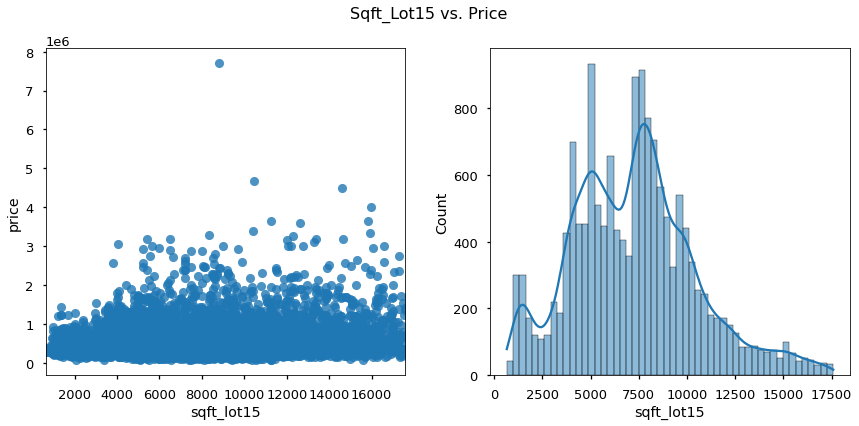

In [122]:
show_cleaned_vis(df,"sqft_lot15")

**Observations**

* 0 SQFT - apartments?


* Slight linear trend, but weak


* Significant outliers with SQFT


**TO-DO**

* Investigate outlier


* Confirm if apt bldgs


*  

# **Feature Engineering**

## `'yrs_old'`

### Determine `'year_sold'`

In [123]:
df['year_sold'] = df['date'].map(lambda x: x[:4])

df['year_sold'] =  df['year_sold'].map(lambda x: int(x))

In [124]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold'],
      dtype='object')

In [125]:
df['year_sold'].value_counts()

2014    11703
2015     5587
Name: year_sold, dtype: int64

In [126]:
df['year_sold'].describe()

count    17290.000000
mean      2014.323135
std          0.467687
min       2014.000000
25%       2014.000000
50%       2014.000000
75%       2015.000000
max       2015.000000
Name: year_sold, dtype: float64

### Calculate `'y_old_sold'`

In [127]:
df['y_old_sold'] = df['year_sold'] - df['yr_built']
df['y_old_sold'].describe()
# min = -1 due to a house being sold before it was finished being built

count    17290.000000
mean        43.531116
std         29.345345
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

In [128]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold',
       'y_old_sold'],
      dtype='object')

In [129]:
df['y_old_sold'].value_counts().sort_index()

-1        7
 0      350
 1      232
 2      141
 3      123
       ... 
 111     41
 112     24
 113     23
 114     55
 115     22
Name: y_old_sold, Length: 117, dtype: int64

In [130]:
df['y_old_sold'].describe()

count    17290.000000
mean        43.531116
std         29.345345
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

## `'was_renovated'`

In [131]:
reno_y_n = np.where(df['yr_renovated']>0, 1, 0 )
df = df.assign(was_renovated = reno_y_n)

In [132]:
df['was_renovated'].value_counts()

0    16564
1      726
Name: was_renovated, dtype: int64

In [133]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'y_old_sold',
       'was_renovated'],
      dtype='object')

## `"yrs_since_reno"`

In [134]:
reno = df[df['was_renovated'] == 1]

# print(reno['year_sold'].isna().sum())

# print(reno['yr_renovated'].isna().sum())

difference = reno['year_sold'] - reno['yr_renovated']

difference

11       17
33       31
67       25
186      29
227      29
         ..
17229    16
17235    10
17239    22
17248    20
17259    15
Length: 726, dtype: int64

In [135]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'y_old_sold',
       'was_renovated'],
      dtype='object')

In [136]:
df = df.assign(yrs_since_reno = difference)

df['yrs_since_reno'].fillna(0, inplace=True)

df['yrs_since_reno'].isnull().sum()

df['yrs_since_reno'].describe()

# min = -1 due to a house being sold before it was finished being built

count    17290.000000
mean         0.772470
std          4.888679
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         80.000000
Name: yrs_since_reno, dtype: float64

## "`has_bsmnt`"

In [137]:
df['has_bsmnt'] = np.where(df['sqft_basement'] > 0, 1, 0)

display(df['has_bsmnt'].describe(), df['has_bsmnt'].value_counts())

count    17290.000000
mean         0.393638
std          0.488570
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: has_bsmnt, dtype: float64

0    10484
1     6806
Name: has_bsmnt, dtype: int64

# **Correlations**

## Determining Correlations with Price

In [138]:
## Determining each feature's relationship with price

df_corr = df.drop(['price', 'id', 'lat','long'], axis=1).corrwith(df['price']).sort_values(ascending=False)
display(df_corr[0:5],df_corr[-6:-1])

sqft_living      0.703540
grade            0.666215
sqft_above       0.607760
sqft_living15    0.585567
bathrooms        0.524335
dtype: float64

yrs_since_reno    0.058501
yr_built          0.056450
condition         0.036099
year_sold        -0.002334
zipcode          -0.048958
dtype: float64

## Determining Multicollinearity

In [139]:
## Get the correlation matrix for the data (without the target)
corr = df.drop('price',axis=1).corr()
corr.round(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
id,1.00,-0.00,0.00,-0.01,-0.13,0.02,0.00,0.01,-0.01,0.00,-0.01,-0.00,0.01,-0.02,-0.01,-0.00,0.02,-0.01,-0.14,0.01,-0.01,-0.02,-0.01,0.00
bedrooms,-0.00,1.00,0.51,0.57,0.03,0.17,-0.01,0.08,0.03,0.35,0.47,0.30,0.15,0.01,-0.15,-0.00,0.12,0.39,0.03,-0.01,-0.15,0.01,-0.01,0.16
bathrooms,0.00,0.51,1.00,0.76,0.09,0.50,0.07,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09,-0.03,-0.51,0.05,-0.01,0.16
sqft_living,-0.01,0.57,0.76,1.00,0.17,0.36,0.11,0.28,-0.06,0.76,0.88,0.44,0.32,0.05,-0.20,0.05,0.23,0.76,0.18,-0.03,-0.32,0.05,0.01,0.20
sqft_lot,-0.13,0.03,0.09,0.17,1.00,-0.00,0.02,0.07,-0.01,0.11,0.18,0.01,0.05,0.00,-0.13,-0.08,0.23,0.14,0.70,0.00,-0.05,0.00,0.01,-0.04
floors,0.02,0.17,0.50,0.36,-0.00,1.00,0.03,0.03,-0.26,0.46,0.53,-0.25,0.48,0.01,-0.06,0.05,0.13,0.28,-0.01,-0.02,-0.48,0.01,-0.00,-0.26
waterfront,0.00,-0.01,0.07,0.11,0.02,0.03,1.00,0.41,0.01,0.09,0.08,0.08,-0.02,0.09,0.03,-0.01,-0.04,0.09,0.03,-0.00,0.02,0.09,0.10,0.04
view,0.01,0.08,0.19,0.28,0.07,0.03,0.41,1.00,0.05,0.25,0.16,0.28,-0.05,0.09,0.09,0.00,-0.08,0.28,0.07,0.00,0.05,0.09,0.08,0.19
condition,-0.01,0.03,-0.12,-0.06,-0.01,-0.26,0.01,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.01,-0.01,-0.11,-0.09,-0.01,-0.04,0.36,-0.06,-0.00,0.13
grade,0.00,0.35,0.66,0.76,0.11,0.46,0.09,0.25,-0.14,1.00,0.76,0.17,0.45,0.01,-0.18,0.12,0.20,0.72,0.12,-0.04,-0.45,0.01,-0.03,0.05


## ƒ: `"corr_val"`

In [140]:
# Create "corr_val" function

def corr_val(df,figsize=(15,15),cmap="OrRd",):
    
    # Calculate correlations
    corr = df.corr()
       
    # Create a mask of the same size as our correlation data
    mask = np.zeros_like(corr)
    
    # Set the upper values of the numpy array to "True" to ignore them
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    
    # Mask=mask to hide the upper-right half of values (otherwise mirrored)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax

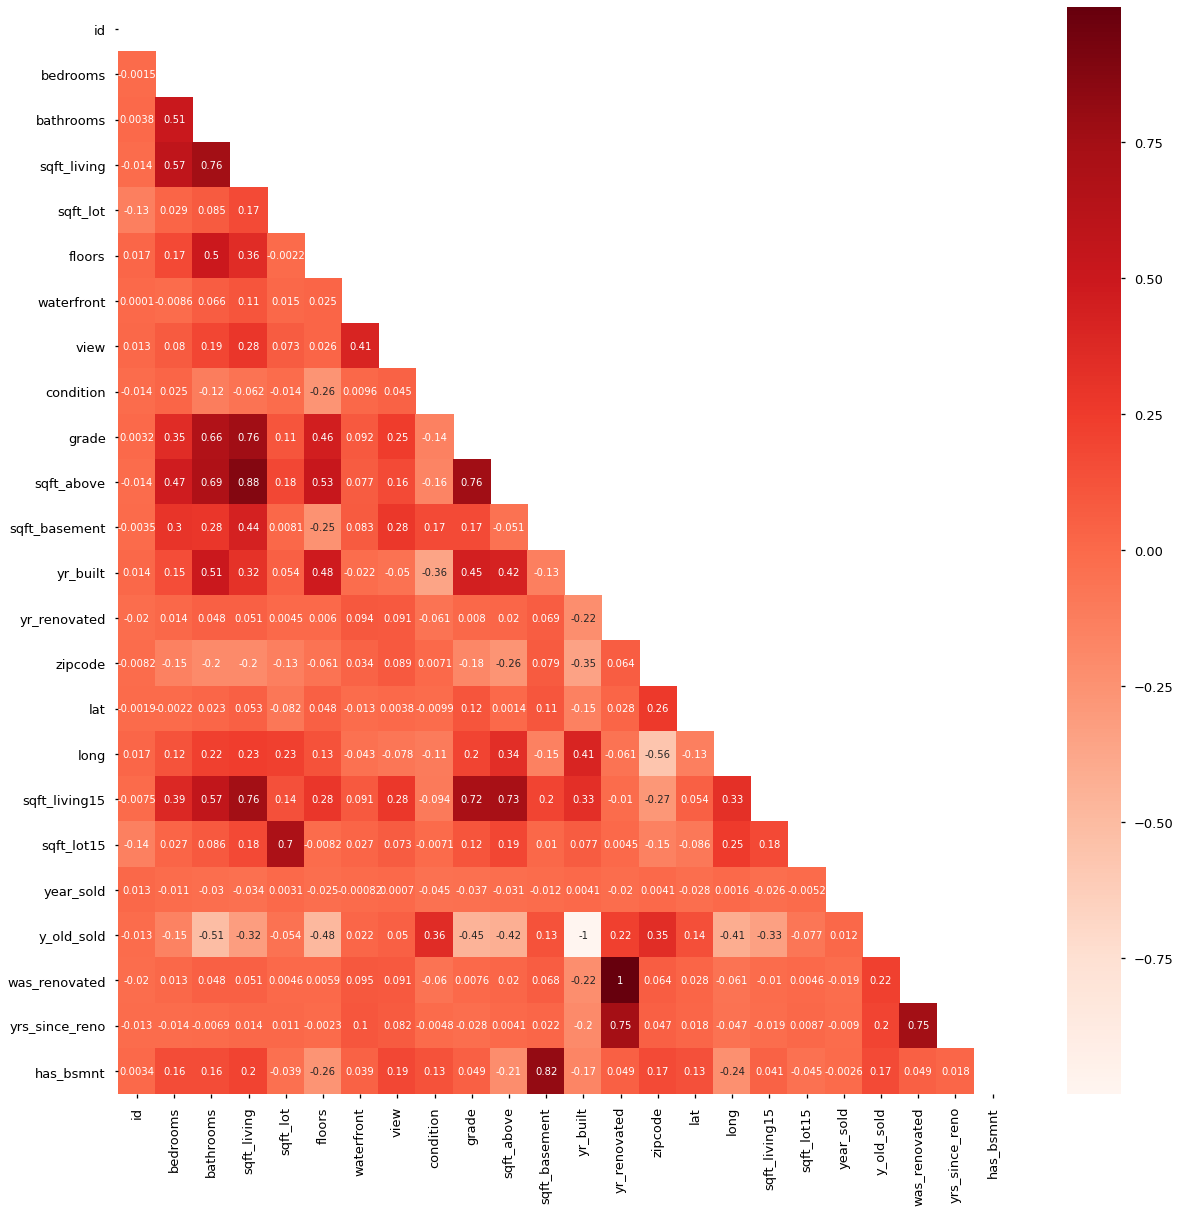

In [141]:
corr_val(df.drop('price',axis=1), figsize=(20,20));

In [142]:
# Correlation results ignoring (most) duplicate values
df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

In [143]:
# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

yr_renovated    was_renovated     0.999968
sqft_living     sqft_above        0.876696
has_bsmnt       sqft_basement     0.818269
sqft_living     grade             0.762929
grade           sqft_above        0.758247
sqft_living     bathrooms         0.755270
sqft_living15   sqft_living       0.755066
was_renovated   yrs_since_reno    0.754774
yrs_since_reno  yr_renovated      0.749501
sqft_living15   sqft_above        0.731077
dtype: float64

sqft_living  y_old_sold      -0.319912
y_old_sold   sqft_living15   -0.332739
zipcode      yr_built        -0.348366
condition    yr_built        -0.358921
long         y_old_sold      -0.407716
sqft_above   y_old_sold      -0.424795
y_old_sold   grade           -0.448558
floors       y_old_sold      -0.484020
y_old_sold   bathrooms       -0.508209
zipcode      long            -0.563027
dtype: float64

In [144]:
# Dropping columns to address multicollinearity (over .8)

df.drop(['yr_renovated','sqft_basement','sqft_above'], axis=1, inplace=True)

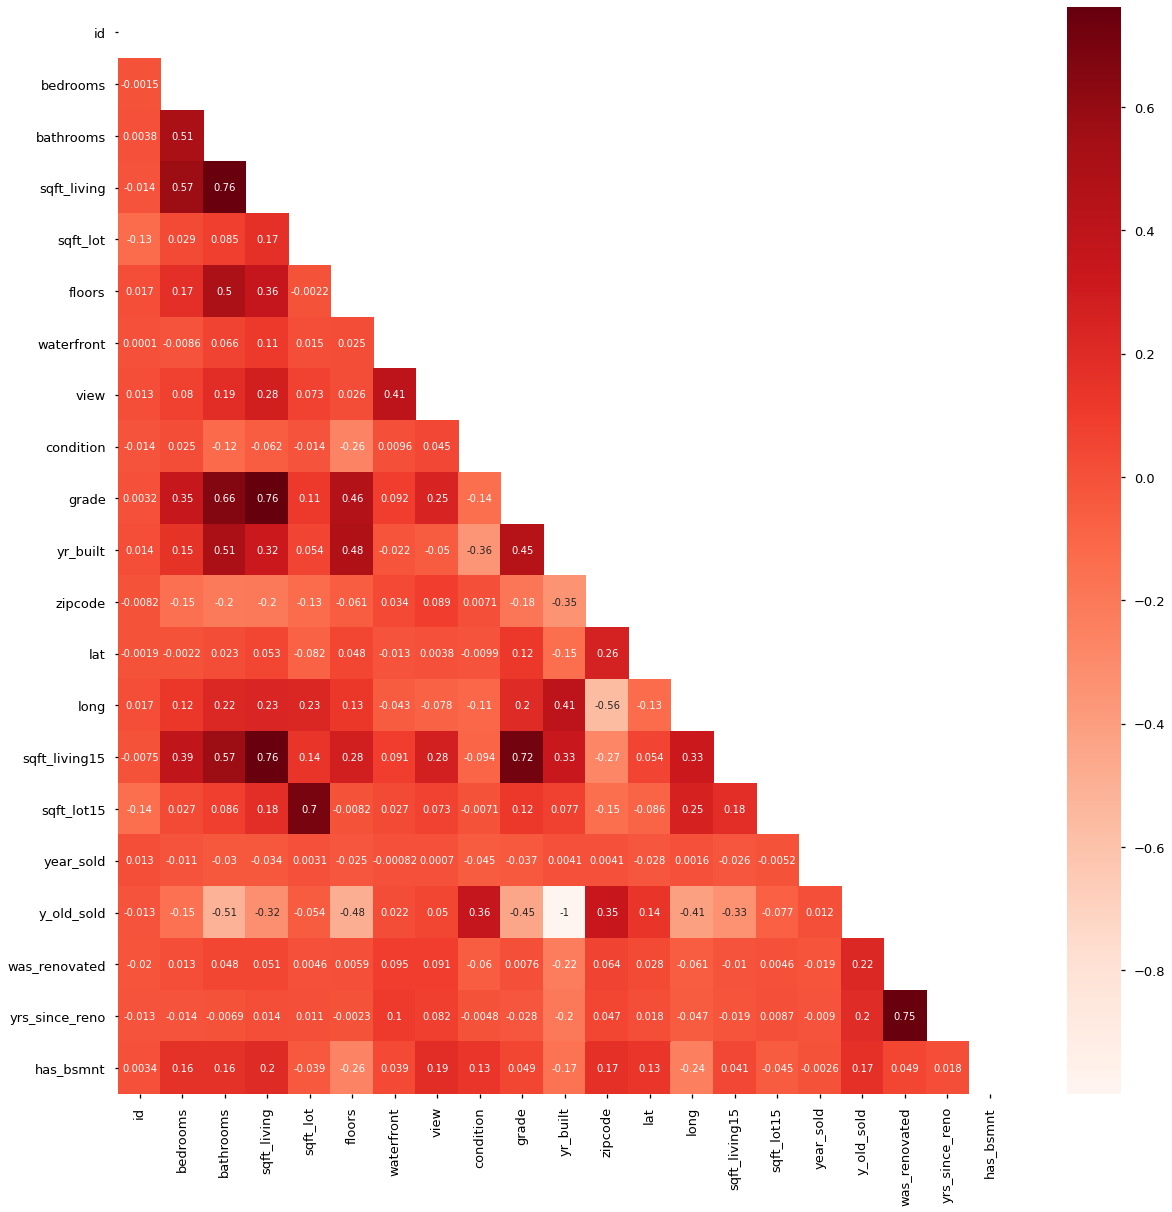

In [145]:
# Rerunning model

corr_val(df.drop('price',axis=1), figsize=(20,20));

In [146]:
# Correlation results ignoring (most) duplicate values
df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

grade           sqft_living      0.762929
sqft_living     bathrooms        0.755270
                sqft_living15    0.755066
yrs_since_reno  was_renovated    0.754774
sqft_living15   grade            0.715745
sqft_living     price            0.703540
sqft_lot        sqft_lot15       0.701875
price           grade            0.666215
grade           bathrooms        0.664191
price           sqft_living15    0.585567
dtype: float64

zipcode      sqft_living15   -0.273903
sqft_living  y_old_sold      -0.319912
y_old_sold   sqft_living15   -0.332739
yr_built     zipcode         -0.348366
condition    yr_built        -0.358921
long         y_old_sold      -0.407716
grade        y_old_sold      -0.448558
y_old_sold   floors          -0.484020
             bathrooms       -0.508209
long         zipcode         -0.563027
dtype: float64

### Interpretation of Correlations

***
**Top 10 Positive Relationships**
>* Nothing too surprising as most of the matches are intuitively related.
>  * E.g. "yr_renovated" and "was_renovated" have a nearly-perfect positive correlation as "was_renovated" is determined by "yr_renovated" in our feature engineering.
>
>
>* Two interesting relationships would be:
>  * The living space (ft^2) and grade
>    * Indicates that a larger house has a higher grade
> * The living space (ft^2) of the 15 nearest houses sold
>   * Indicates a larger area above ground (ft^2)
>    * Perhaps larger houses are more likely to be nearby each other?
***
**Top 10 Negative Relationships**
>* Older houses may have fewer bathrooms
>* Older houses may have fewer floors
>* Older houses have a lower grade
***

# **Statistical Testing**

## One-Way ANOVA

### *Testing `'condition'`*

* H0: The feature "condition" does not have an effect on price.

* Ha: The feature "condition" does  have an effect on price.


In [147]:
## Defining variables for the prices of each value of conditions

condition_1 = df.loc[df['condition'] == 1, 'price']
condition_2 = df.loc[df['condition'] == 2, 'price']
condition_3 = df.loc[df['condition'] == 3, 'price']
condition_4 = df.loc[df['condition'] == 4, 'price']
condition_5 = df.loc[df['condition'] == 5, 'price']

In [148]:
## Running ANOVA test to determine significance

# Define alpha
alpha = .05

# Run test
result = stats.f_oneway(condition_1, condition_2, condition_3, condition_4, condition_5)
f_stat, p_value = result

# Evaluate if significant or not
if p_value < .05:
    print(f'The condition of a home is statistically significant with a p-value of {p_value}.')
    
else:
     print(f'The condition of a home is not statistically significant with a p-value of {p_value}.')

The condition of a home is statistically significant with a p-value of 6.813536869427384e-24.


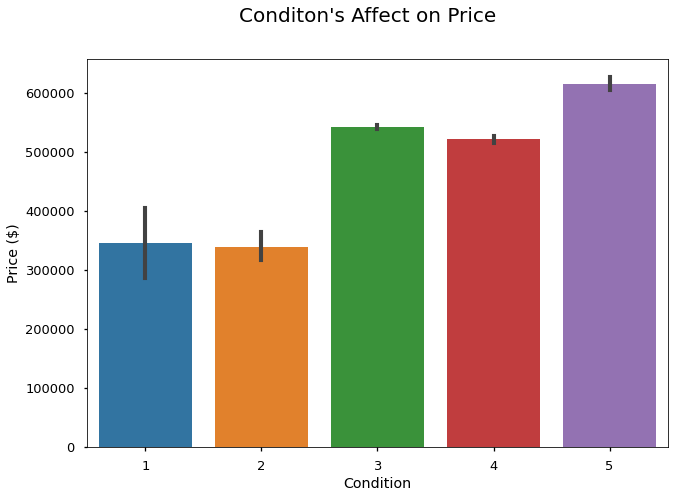

In [149]:
# Show visual of conclusion

sns.barplot(data=df, x= 'condition', y = 'price', ci=68)
plt.suptitle("Conditon's Affect on Price", size = (20))
plt.xlabel('Condition')
plt.ylabel('Price ($)');

#### Interpretation

> The t-test shows that the condition of a house is statistically significant due to the p-value below our alpha of .05.
>
> This means that the quality of a house will have a statistically significant impact on the sell price.

## Two-Sample T-Tests

### *Testing  `'waterfront'`*

* H0: The feature "waterfront" does not have an effect on price.

* Ha: The feature "waterfront" does  have an effect on price.


* Alpha = .05

In [150]:
# Set variables to represent whether or not a property is listed as 'waterfront.'

wf_yes = df.loc[df['waterfront'] == 1, 'price']
wf_no = df.loc[df['waterfront'] == 0, 'price']

In [151]:
ttest_review(wf_yes, wf_no)

The feature "waterfront" is statistically significant with a p-value of 2.465038317654299e-299.


2.465038317654299e-299

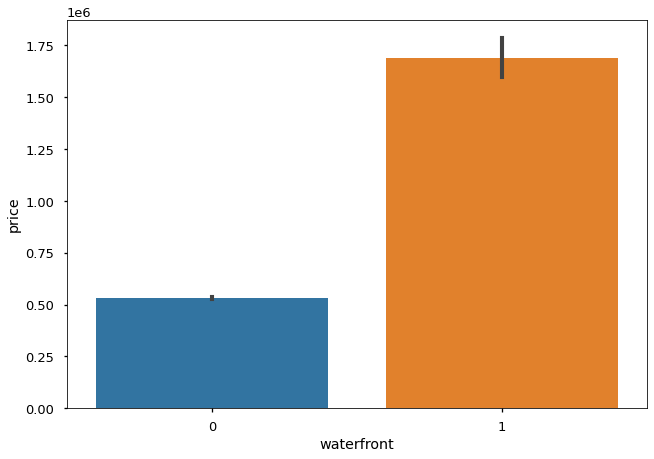

In [152]:
# Show visual of conclusion

sns.barplot(data=df, x= 'waterfront', y = 'price', ci=68);

#### Interpretation

> The t-test shows that waterfront is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house on the waterfront will have a significant impact on the sell price.

### *Testing `"was_renovated"`*

**Hypotheses**

---
>**H0:** There is not a statistically significant difference in price in homes with a basement than those without.
>
>**HA:** There is a statistically significant difference in price in homes with a basement than those without.
---

In [153]:
reno_y = df.loc[df['was_renovated'] == 1, 'price']
reno_n = df.loc[df['was_renovated'] == 0, 'price']


In [154]:
ttest_review(reno_y, reno_n)

The feature "waterfront" is statistically significant with a p-value of 4.007705820364685e-54.


4.007705820364685e-54

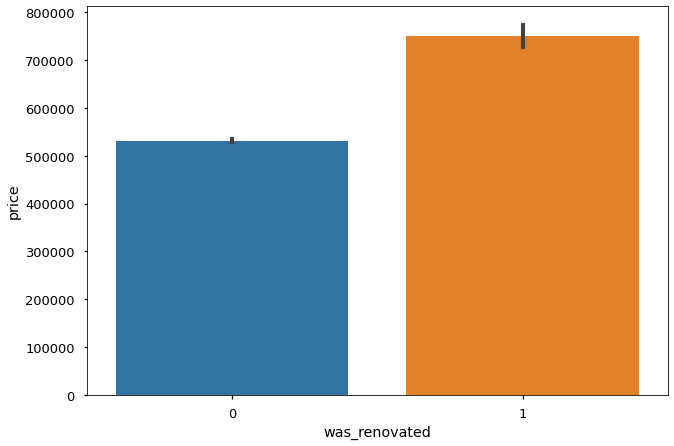

In [155]:
# Show visual of conclusion

sns.barplot(data=df, x= 'was_renovated', y = 'price', ci=68);

#### Interpretation

> The t-test shows that having a basement is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house with a basement will have a significant impact on the sell price.

# **Modeling**

## Define Functions

### ƒ: `create_model`

In [156]:
def create_model(data, cont, cat):
    '''------
    
    * Creates a linear regression model using Statsmodels OLS
    * Save the 
    
    ---
    
    * Args:
        * Data: dataframe as data source
        * Cont: list of continuous variables
        * Cat: list of categorical variables
        * unique_id: UNIQUE name for the resulting model
    
    -----
    '''

    cont_features = '+'.join(cont)

    cat_features = '+'.join([f'C({x})' for x in cat])

    f = f'price~+{cont_features}+{cat_features}'

    print(f)

    model = smf.ols(formula=f, data=data).fit()
   
    diagnose_model(model)
    
    return model

### ƒ: `diagnose_model`

>* Create a function to:
>  * Display the summary details of the model
>  * Create a scatter plot of the predictions
>    * Used for determining homoscedasticity
>  * Create a Q-Q plot of the residuals of the model
>    * Used to determine the normality of the residuals


In [157]:
def diagnose_model(model, figsize=(10,5)):
    """ ---
    
    Argument:
        * model: provide the linear regression model for diagnostics
    
    Keyword Argument:
        * figsize: default (10,5); can increase/decrease for larger/smaller
    ---
    
    * Display the summary details of the provided model
    * Create two scatter plots to test assumptions of linearity
        * Predictions: verifying homoscedasticity (no cone-shapes)
        * Residuals: confirming normal distribution of residuals
    ---
    
    """
    display(model.summary())
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    axes[0].scatter(model.predict(), model.resid)
    axes[0].axhline()
    axes[0].set_xlabel('Model Predictions')
    axes[0].set_ylabel('Model Residuals')
    axes[0].set_title('Testing for Homoscedasticity')

    sms.graphics.qqplot(data=model.resid, fit=True, line = "45", ax=axes[1])
    
    plt.tight_layout()
    
    return

### ƒ: `plot_param_coef`

>* Create a function to:
>  * Get the model's coefficients as a series
>  * Plot a figure to show the coefficients in descending order


In [158]:
def plot_param_coef(model, kind = 'barh', figsize = (10,5)):
    ''' ---
    
    * Plotting a figure to visualize parameter coefficients
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default (10,10)): allows for different sizes
    ---
    
    '''
    # Plotting figure to visualize parameter coefficients

    ## Getting coefficients as a Series
    params = model.params[1:]
    params.sort_values(inplace=True)

    plt.figure(figsize=figsize) # Used if large number of params
    ax = params.plot(kind=kind)
    ax.axvline()
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Features')
    ax.set_title('Comparing Feature Coefficients')
    
    plt.tight_layout()
    
    return

### ƒ: `plot_p_values`

>* Create a function to:
>  * Get the model's p-values as a series
>  * Plot a figure to show the p-values in descending order

In [159]:
def plot_p_values(model, kind = 'barh', size = None, alpha = .05):
    ''' ---
    
    * Plots a figure to visualize parameter p-values exceeding stated alpha.
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default None): allows for different sizes
    ---
    
    '''
    
    pv = model.pvalues[1:]
    pv_high = pv[pv > alpha]
    pv_low = pv[pv <= alpha]
    pv_high.sort_values(ascending=False, inplace=True)
    
    if len(pv_high) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_high.plot(kind=kind)
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values')
        
    if len(pv_low) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values Below {alpha}')        
        
#     else:
#         print(f'There are no p-values above {alpha}.')
        
    plt.tight_layout()
    
    return

### ƒ: `review_model` (Combined)

In [160]:
def review_model(model):
    '''---
    
    Combines earlier functions into one all-purpose function for reviewing
    model performance.
    
    ---
    
    Arg:
        * model: Specify model to review.
        
    ---'''
    
    diagnose_model(model)
    
    plot_param_coef(model)
    
    plot_p_values(model)
    
    return    

## Baseline Model

In [161]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1970.792019,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,2014.323135,43.531116,0.041990,0.772470,0.393638
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,29.343516,53.607949,0.138412,0.140857,684.802635,27227.437583,0.467687,29.345345,0.200571,4.888679,0.488570
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,2014.000000,-1.000000,0.000000,-1.000000,0.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,2014.000000,18.000000,0.000000,0.000000,0.000000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1974.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,2014.000000,40.000000,0.000000,0.000000,0.000000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,2015.000000,63.000000,0.000000,0.000000,1.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,2015.000000,115.000000,1.000000,80.000000,1.000000


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              17290 non-null  int64  
 1   date            17290 non-null  object 
 2   price           17290 non-null  float64
 3   bedrooms        17290 non-null  int64  
 4   bathrooms       17290 non-null  float64
 5   sqft_living     17290 non-null  int64  
 6   sqft_lot        17290 non-null  int64  
 7   floors          17290 non-null  float64
 8   waterfront      17290 non-null  int64  
 9   view            17290 non-null  int64  
 10  condition       17290 non-null  int64  
 11  grade           17290 non-null  int64  
 12  yr_built        17290 non-null  int64  
 13  zipcode         17290 non-null  int64  
 14  lat             17290 non-null  float64
 15  long            17290 non-null  float64
 16  sqft_living15   17290 non-null  int64  
 17  sqft_lot15      17290 non-null 

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     2576.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:45:07   Log-Likelihood:            -2.3848e+05
No. Observations:               17290   AIC:                         4.770e+05
Df Residuals:                   17279   BIC:                         4.771e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.531e+06   1.81e+04    -84.504      0.000   -1.57e+06    -1.5e+06
C(was_renovated)[T.1]  5.842e+04   1.41e+04      4.130      0.000    3.07e+04    8.62e+04
C(has_bsmnt)[T.1]      3.158e+04   4156.712      7.597      0.000    2.34e+04    3.97e+04
C(waterfront)[T.1]     8.042e+05   2.05e+04     39.232      0.000    7.64e+05    8.44e+05
y_old_sold             4325.6941     85.480     50.605      0.000    4158.144    4493.244
yrs_since_reno        -2511.5735    564.503     -4.449      0.000   -3618.057   -1405.090
bedrooms              -2081.5430   2266.058     -0.919      0.358   -6523.247    2360.161
bathrooms               1.25e+05   3930.644     31.793      0.000    1.17e+05    1.33e+05
condition              2.008e+04   3045.263      6.594      0.000    1.41e+04     2.6e+04
grade                   1.98e+05   2117.430     93.491      0.000    1.94e+05    2.02e+05
floors                 1.586e+04   4400.252      3.604      0.000    7232.686    2.45e+04
==============================================================================
Omnibus:                    15571.873   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1844101.619
Skew:                           3.873   Prob(JB):                         0.00
Kurtosis:                      52.998   Cond. No.                         610.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

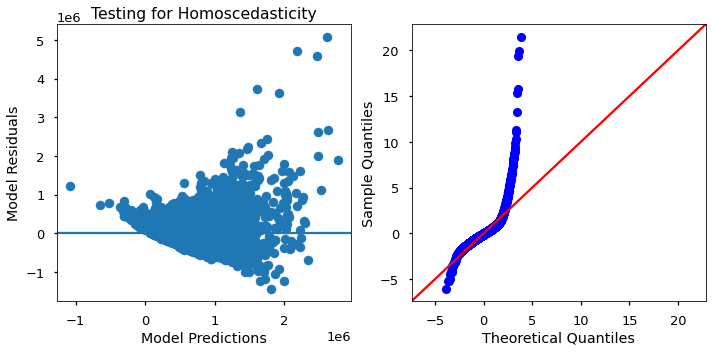

In [163]:
categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

create_model(df,continuous_features,categorical_features);

Interpretation:

* R^2: ~.6, less than target of .75

* Residual plots show heteroscedasticity

* Q-Q Plot shows non-normal residuals

* Changes: remove outliers and retest

## Model - W/O Outliers

### Removing Outliers from 'Price' Data

In [164]:
## Remove outliers from price 
idx_outs = find_outliers_z(df['price'])
df_clean = df[~idx_outs].copy()
df_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,1986,98058,47.4388,-122.162,2390,7700,2014,28,0,0.0,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1977,98115,47.6784,-122.285,2370,6283,2014,37,0,0.0,1
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,1997,98006,47.5646,-122.129,3710,9685,2014,17,0,0.0,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,1990,98034,47.6995,-122.228,4050,14226,2015,25,0,0.0,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2004,98052,47.6647,-122.083,2250,4050,2014,10,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,1958,98008,47.5858,-122.112,2730,10400,2015,57,0,0.0,1
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1948,98105,47.6687,-122.288,1350,4013,2014,66,0,0.0,0
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1953,98028,47.7635,-122.262,1760,9403,2014,61,0,0.0,0
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1971,98038,47.4199,-121.990,2080,108028,2014,43,0,0.0,1


In [165]:
## Remove outliers from bedrooms
idx_outs = find_outliers_z(df_clean['bedrooms'])
df_clean = df_clean[~idx_outs].copy()

df_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,1986,98058,47.4388,-122.162,2390,7700,2014,28,0,0.0,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1977,98115,47.6784,-122.285,2370,6283,2014,37,0,0.0,1
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,1997,98006,47.5646,-122.129,3710,9685,2014,17,0,0.0,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,1990,98034,47.6995,-122.228,4050,14226,2015,25,0,0.0,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2004,98052,47.6647,-122.083,2250,4050,2014,10,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,1958,98008,47.5858,-122.112,2730,10400,2015,57,0,0.0,1
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1948,98105,47.6687,-122.288,1350,4013,2014,66,0,0.0,0
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1953,98028,47.7635,-122.262,1760,9403,2014,61,0,0.0,0
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1971,98038,47.4199,-121.990,2080,108028,2014,43,0,0.0,1


In [166]:
df_clean.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
count,1.692300e+04,1.692300e+04,16923.000000,16923.000000,16923.00000,1.692300e+04,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000
mean,4.580302e+09,5.068460e+05,3.346038,2.081856,2030.81209,1.502735e+04,1.482302,0.004668,0.210010,3.407375,7.602494,1970.751994,98078.442416,47.558885,-122.213853,1961.790995,12762.476629,2014.323170,43.571175,0.040064,0.746381,0.388170
std,2.875948e+09,2.594154e+05,0.871877,0.731297,831.18918,4.172312e+04,0.536899,0.068167,0.717421,0.649637,1.107905,29.237036,53.534877,0.139363,0.141553,654.638580,27137.875033,0.467701,29.239539,0.196115,4.855077,0.487348
min,1.000102e+06,7.500000e+04,1.000000,0.000000,370.00000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,2014.000000,-1.000000,0.000000,-1.000000,0.000000
25%,2.123049e+09,3.200000e+05,3.000000,1.500000,1420.00000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,98033.000000,47.466900,-122.330000,1480.000000,5100.000000,2014.000000,18.000000,0.000000,0.000000,0.000000
50%,3.904940e+09,4.464500e+05,3.000000,2.250000,1900.00000,7.587000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1974.000000,98065.000000,47.569600,-122.230000,1830.000000,7597.000000,2014.000000,40.000000,0.000000,0.000000,0.000000
75%,7.309100e+09,6.290000e+05,4.000000,2.500000,2500.00000,1.051150e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.678750,-122.124000,2330.000000,10004.500000,2015.000000,63.000000,0.000000,0.000000,1.000000
max,9.900000e+09,1.655000e+06,6.000000,6.000000,7350.00000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,858132.000000,2015.000000,115.000000,1.000000,80.000000,1.000000


price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     2422.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:45:08   Log-Likelihood:            -2.2746e+05
No. Observations:               16923   AIC:                         4.549e+05
Df Residuals:                   16912   BIC:                         4.550e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.162e+06   1.35e+04    -86.344      0.000   -1.19e+06   -1.14e+06
C(was_renovated)[T.1]   5.14e+04   1.02e+04      5.021      0.000    3.13e+04    7.15e+04
C(has_bsmnt)[T.1]      4.068e+04   2964.749     13.721      0.000    3.49e+04    4.65e+04
C(waterfront)[T.1]      3.24e+05   1.89e+04     17.130      0.000    2.87e+05    3.61e+05
y_old_sold             3284.2377     62.183     52.816      0.000    3162.353    3406.122
yrs_since_reno        -1913.9577    402.413     -4.756      0.000   -2702.729   -1125.187
bedrooms               5271.9827   1739.192      3.031      0.002    1862.984    8680.981
bathrooms              7.191e+04   2921.530     24.613      0.000    6.62e+04    7.76e+04
condition              2.121e+04   2167.706      9.783      0.000     1.7e+04    2.55e+04
grade                  1.593e+05   1562.805    101.927      0.000    1.56e+05    1.62e+05
floors                 3.852e+04   3166.597     12.164      0.000    3.23e+04    4.47e+04
==============================================================================
Omnibus:                     2820.763   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7575.714
Skew:                           0.908   Prob(JB):                         0.00
Kurtosis:                       5.728   Cond. No.                         784.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

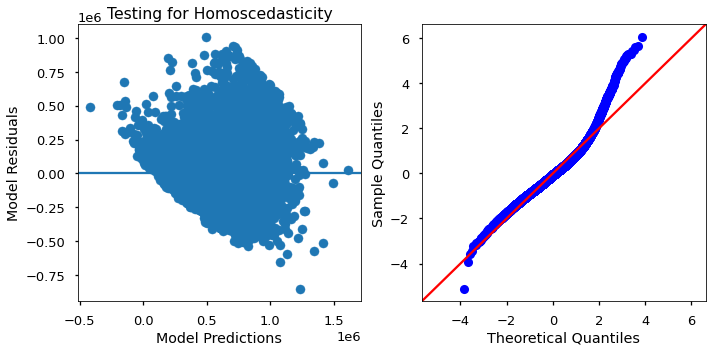

In [167]:
categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

create_model(df_clean,cont=continuous_features,cat=categorical_features);

Interpretation:

* R^2: ~.59, less than target of .75

* Residual plots show somewhat homoscedasticity

* Q-Q Plot shows more normal residuals (vs. earlier plot)

* Changes: add zipcode 

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     2422.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:45:35   Log-Likelihood:            -2.2746e+05
No. Observations:               16923   AIC:                         4.549e+05
Df Residuals:                   16912   BIC:                         4.550e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.162e+06   1.35e+04    -86.344      0.000   -1.19e+06   -1.14e+06
C(was_renovated)[T.1]   5.14e+04   1.02e+04      5.021      0.000    3.13e+04    7.15e+04
C(has_bsmnt)[T.1]      4.068e+04   2964.749     13.721      0.000    3.49e+04    4.65e+04
C(waterfront)[T.1]      3.24e+05   1.89e+04     17.130      0.000    2.87e+05    3.61e+05
y_old_sold             3284.2377     62.183     52.816      0.000    3162.353    3406.122
yrs_since_reno        -1913.9577    402.413     -4.756      0.000   -2702.729   -1125.187
bedrooms               5271.9827   1739.192      3.031      0.002    1862.984    8680.981
bathrooms              7.191e+04   2921.530     24.613      0.000    6.62e+04    7.76e+04
condition              2.121e+04   2167.706      9.783      0.000     1.7e+04    2.55e+04
grade                  1.593e+05   1562.805    101.927      0.000    1.56e+05    1.62e+05
floors                 3.852e+04   3166.597     12.164      0.000    3.23e+04    4.47e+04
==============================================================================
Omnibus:                     2820.763   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7575.714
Skew:                           0.908   Prob(JB):                         0.00
Kurtosis:                       5.728   Cond. No.                         784.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

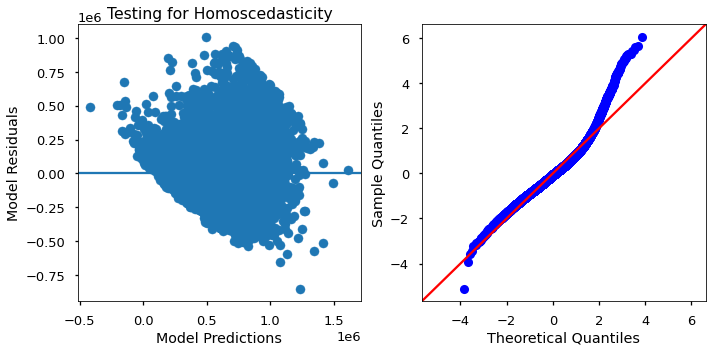

In [173]:
categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

create_model(df_clean,continuous_features,categorical_features);

## Model - w/ Zip Codes

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     723.0
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:45:36   Log-Likelihood:            -2.2246e+05
No. Observations:               16923   AIC:                         4.451e+05
Df Residuals:                   16843   BIC:                         4.457e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.082e+05   1.29e+04    -70.617      0.000   -9.33e+05   -8.83e+05
C(was_renovated)[T.1]  5.205e+04   7669.920      6.786      0.000     3.7e+04    6.71e+04
C(has_bsmnt)[T.1]      4194.0254   2410.118      1.740      0.082    -530.059    8918.109
C(waterfront)[T.1]     4.146e+05   1.46e+04     28.492      0.000    3.86e+05    4.43e+05
C(zipcode)[T.98002]    7700.3206   1.24e+04      0.622      0.534   -1.66e+04     3.2e+04
C(zipcode)[T.98003]   -2.942e+04   1.11e+04     -2.651      0.008   -5.12e+04   -7666.780
C(zipcode)[T.98004]    6.095e+05   1.21e+04     50.472      0.000    5.86e+05    6.33e+05
C(zipcode)[T.98005]    2.997e+05    1.3e+04     22.968      0.000    2.74e+05    3.25e+05
C(zipcode)[T.98006]    2.806e+05   9970.638     28.143      0.000    2.61e+05       3e+05
C(zipcode)[T.98007]    2.074e+05   1.35e+04     15.307      0.000    1.81e+05    2.34e+05
C(zipcode)[T.98008]    2.307e+05   1.12e+04     20.617      0.000    2.09e+05    2.53e+05
C(zipcode)[T.98010]    1.156e+05   1.62e+04      7.135      0.000    8.39e+04    1.47e+05
C(zipcode)[T.98011]    1.349e+05   1.22e+04     11.047      0.000    1.11e+05    1.59e+05
C(zipcode)[T.98014]    1.667e+05   1.44e+04     11.542      0.000    1.38e+05    1.95e+05
C(zipcode)[T.98019]    1.188e+05   1.27e+04      9.368      0.000     9.4e+04    1.44e+05
C(zipcode)[T.98022]    3.376e+04   1.17e+04      2.892      0.004    1.09e+04    5.66e+04
C(zipcode)[T.98023]   -3.732e+04   9591.428     -3.891      0.000   -5.61e+04   -1.85e+04
C(zipcode)[T.98024]    2.266e+05   1.73e+04     13.095      0.000    1.93e+05    2.61e+05
C(zipcode)[T.98027]    1.868e+05   1.01e+04     18.439      0.000    1.67e+05    2.07e+05
C(zipcode)[T.98028]    1.311e+05   1.12e+04     11.735      0.000    1.09e+05    1.53e+05
C(zipcode)[T.98029]    1.883e+05   1.09e+04     17.344      0.000    1.67e+05     2.1e+05
C(zipcode)[T.98030]   -7414.8887   1.14e+04     -0.648      0.517   -2.98e+04     1.5e+04
C(zipcode)[T.98031]   -5749.4528   1.12e+04     -0.511      0.609   -2.78e+04    1.63e+04
C(zipcode)[T.98032]   -1.688e+04   1.43e+04     -1.181      0.238   -4.49e+04    1.11e+04
C(zipcode)[T.98033]    3.474e+05   9992.388     34.769      0.000    3.28e+05    3.67e+05
C(zipcode)[T.98034]    1.682e+05   9518.772     17.668      0.000     1.5e+05    1.87e+05
C(zipcode)[T.98038]     5.18e+04   9424.092      5.497      0.000    3.33e+04    7.03e+04
C(zipcode)[T.98039]    8.197e+05   3.19e+04     25.677      0.000    7.57e+05    8.82e+05
C(zipcode)[T.98040]    4.667e+05   1.17e+04     39.877      0.000    4.44e+05     4.9e+05
C(zipcode)[T.98042]    1.474e+04   9540.112      1.545      0.122   -3957.891    3.34e+04
C(zipcode)[T.98045]    1.216e+05   1.19e+04     10.209      0.000    9.83e+04    1.45e+05
C(zipcode)[T.98052]    

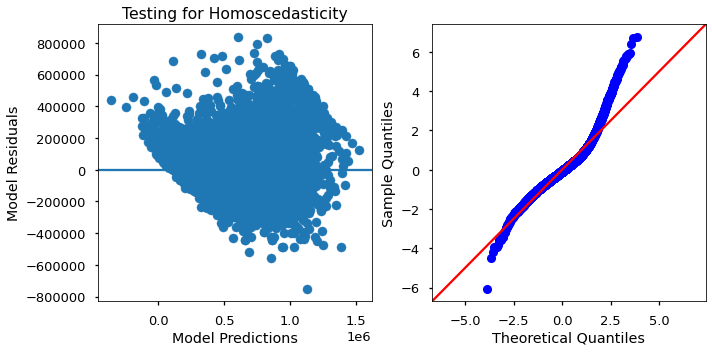

In [174]:
categorical_features = ['was_renovated','has_bsmnt', 'waterfront', 'zipcode']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_w_zip = create_model(df_clean,continuous_features, categorical_features)

Interpretation:

* R^2: ~.77, greater than target of .75

* Residual plots show somewhat homoscedasticity

* Q-Q Plot shows more normal residuals (vs. earlier plot)

* Changes: remove features with p-values higher than .05

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+C(was_renovated)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     741.2
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:45:54   Log-Likelihood:            -2.2246e+05
No. Observations:               16923   AIC:                         4.451e+05
Df Residuals:                   16845   BIC:                         4.457e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.145e+05   1.26e+04    -72.433      0.000   -9.39e+05    -8.9e+05
C(was_renovated)[T.1]  5.184e+04   7671.429      6.757      0.000    3.68e+04    6.69e+04
C(waterfront)[T.1]     4.146e+05   1.45e+04     28.510      0.000    3.86e+05    4.43e+05
C(zipcode)[T.98002]    6498.2936   1.24e+04      0.525      0.599   -1.78e+04    3.08e+04
C(zipcode)[T.98003]    -2.86e+04   1.11e+04     -2.577      0.010   -5.03e+04   -6842.006
C(zipcode)[T.98004]    6.101e+05   1.21e+04     50.523      0.000    5.86e+05    6.34e+05
C(zipcode)[T.98005]    3.014e+05    1.3e+04     23.107      0.000    2.76e+05    3.27e+05
C(zipcode)[T.98006]    2.818e+05   9965.649     28.272      0.000    2.62e+05    3.01e+05
C(zipcode)[T.98007]    2.073e+05   1.36e+04     15.295      0.000    1.81e+05    2.34e+05
C(zipcode)[T.98008]     2.32e+05   1.12e+04     20.739      0.000     2.1e+05    2.54e+05
C(zipcode)[T.98010]    1.148e+05   1.62e+04      7.083      0.000     8.3e+04    1.47e+05
C(zipcode)[T.98011]     1.35e+05   1.22e+04     11.057      0.000    1.11e+05    1.59e+05
C(zipcode)[T.98014]    1.658e+05   1.44e+04     11.478      0.000    1.37e+05    1.94e+05
C(zipcode)[T.98019]    1.179e+05   1.27e+04      9.296      0.000    9.31e+04    1.43e+05
C(zipcode)[T.98022]    3.311e+04   1.17e+04      2.836      0.005    1.02e+04     5.6e+04
C(zipcode)[T.98023]   -3.635e+04   9589.388     -3.791      0.000   -5.51e+04   -1.76e+04
C(zipcode)[T.98024]    2.261e+05   1.73e+04     13.063      0.000    1.92e+05     2.6e+05
C(zipcode)[T.98027]     1.87e+05   1.01e+04     18.496      0.000    1.67e+05    2.07e+05
C(zipcode)[T.98028]    1.316e+05   1.12e+04     11.782      0.000     1.1e+05    1.54e+05
C(zipcode)[T.98029]    1.866e+05   1.08e+04     17.204      0.000    1.65e+05    2.08e+05
C(zipcode)[T.98030]   -7704.2765   1.14e+04     -0.673      0.501   -3.01e+04    1.47e+04
C(zipcode)[T.98031]   -5857.5752   1.12e+04     -0.521      0.602   -2.79e+04    1.62e+04
C(zipcode)[T.98032]   -1.643e+04   1.43e+04     -1.149      0.250   -4.44e+04    1.16e+04
C(zipcode)[T.98033]    3.475e+05   9994.606     34.769      0.000    3.28e+05    3.67e+05
C(zipcode)[T.98034]    1.693e+05   9515.521     17.787      0.000    1.51e+05    1.88e+05
C(zipcode)[T.98038]    5.042e+04   9417.311      5.353      0.000     3.2e+04    6.89e+04
C(zipcode)[T.98039]    8.205e+05   3.19e+04     25.699      0.000    7.58e+05    8.83e+05
C(zipcode)[T.98040]    4.675e+05   1.17e+04     39.945      0.000    4.45e+05     4.9e+05
C(zipcode)[T.98042]    1.417e+04   9540.489      1.486      0.137   -4526.835    3.29e+04
C(zipcode)[T.98045]    1.213e+05   1.19e+04     10.179      0.000    9.79e+04    1.45e+05
C(zipcode)[T.98052]    2.326e+05   9362.476     24.843      0.000    2.14e+05    2.51e+05
C(zipcode)[T.98053]    

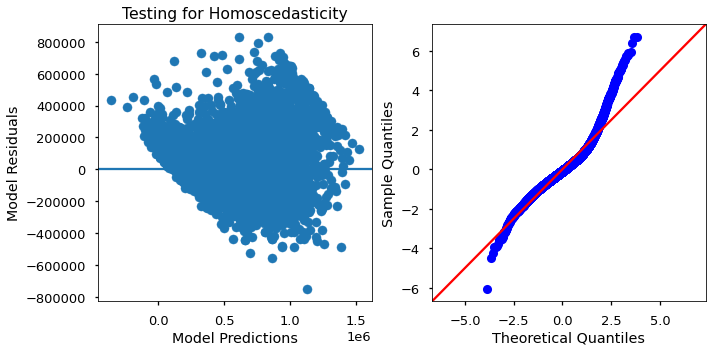

In [177]:
categorical_features = ['was_renovated','waterfront', 'zipcode']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade']

model_clean = create_model(data=df_clean, cont=continuous_features, cat=categorical_features)

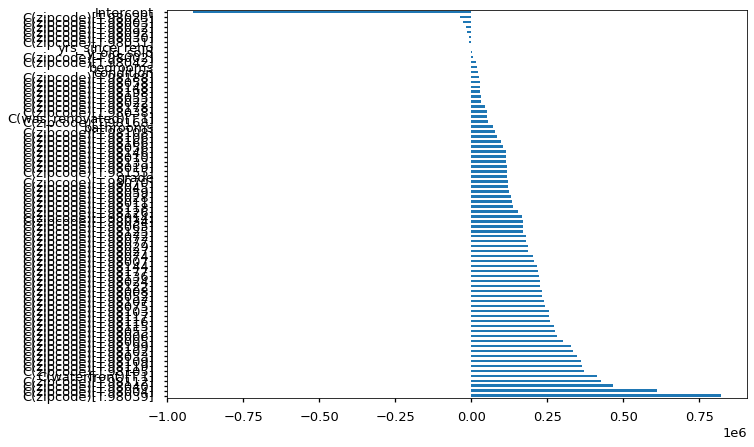

In [178]:
coeff_clean = model_clean.params.sort_values(ascending=False)
coeff_clean.plot(kind='barh');

In [179]:
coeff_clean.sort_values(ascending=False)

C(zipcode)[T.98039]    820544.516607
C(zipcode)[T.98004]    610089.190752
C(zipcode)[T.98040]    467462.730818
C(zipcode)[T.98112]    427655.083325
C(waterfront)[T.1]     414606.128026
                           ...      
C(zipcode)[T.98092]    -14245.855335
C(zipcode)[T.98032]    -16427.663399
C(zipcode)[T.98003]    -28595.153574
C(zipcode)[T.98023]    -36350.799709
Intercept             -914452.120019
Length: 78, dtype: float64

### Recommendations

* Add bathroom
* Use high-quality materials in renovations
* Zip code will have large effect on price, but beyond homeowner's control
* Also consider adding bedrooms

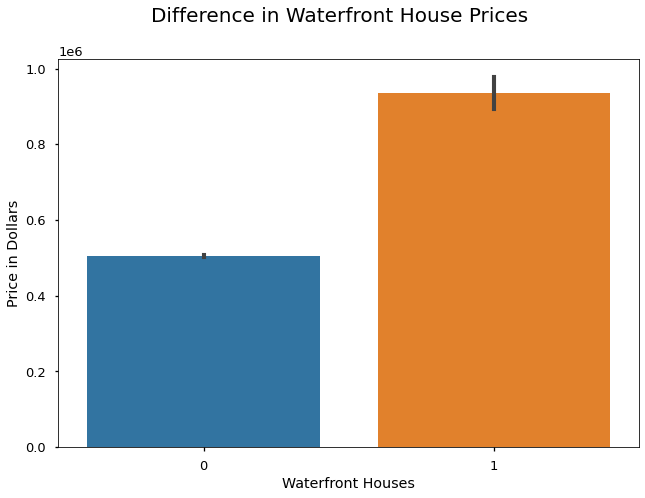

In [180]:
fg1 = sns.barplot(data=df_clean, x='waterfront', y='price', ci=68)
fg1.set_xlabel('Waterfront Houses')
fg1.set_ylabel('Price in Dollars')
plt.suptitle('Difference in Waterfront House Prices', size=20);


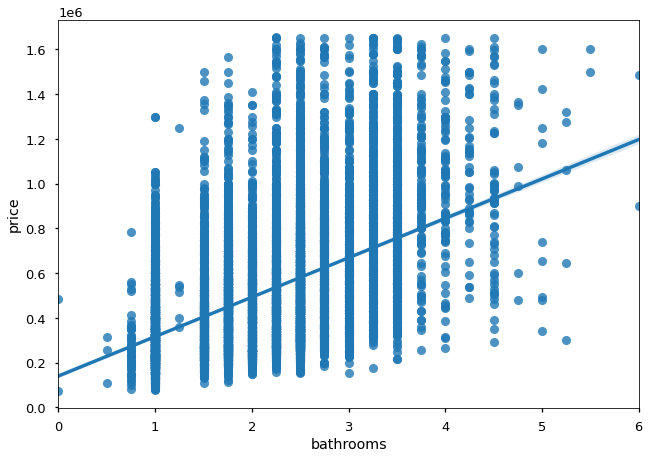

In [181]:
sns.regplot(data=df_clean, x="bathrooms", y='price');

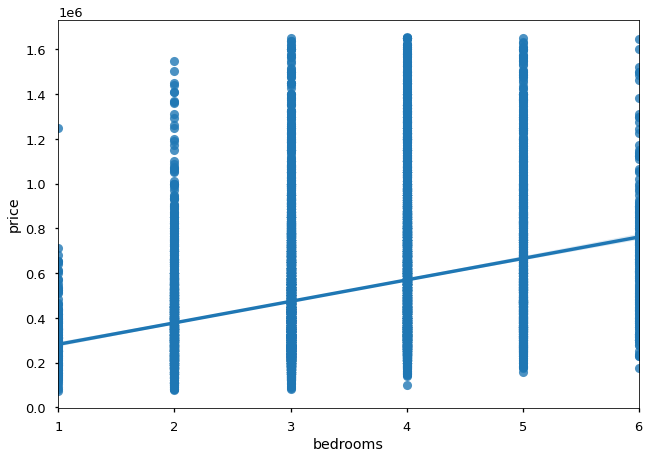

In [182]:
sns.regplot(data=df_clean, x="bedrooms", y='price');

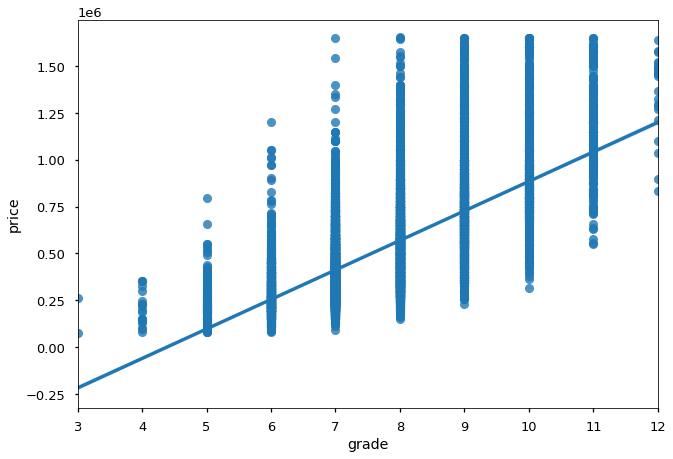

In [183]:
sns.regplot(data=df_clean, x="grade", y='price');

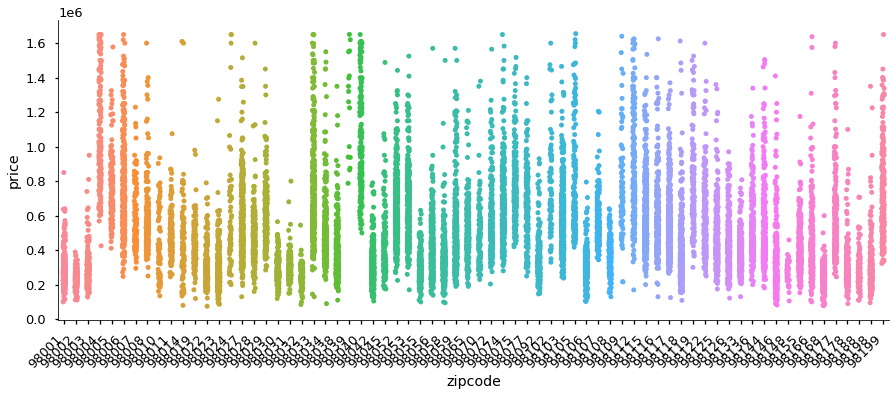

In [184]:
fg = sns.catplot(data=df_clean, x="zipcode", y='price', aspect=2.5, height=5)
fg.ax.set_xticklabels(fg.ax.get_xticklabels(), rotation=45, ha='right');

# Model Testing

Now that I have a working model, I want to go ahead and test it to see how well it works. I will split the data in a 75/25 split into two groups; train a model on the 75%; and then compare it against the remaining 25%. My goal is to have a Root Mean Squared Error (RMSE) less than 200,000.

## ID Features, Target

In [185]:
## Save the features that we used previously - I will use these features 
## to fit my model.

X = df_clean[['was_renovated','waterfront', 'zipcode', 'y_old_sold',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()

In [186]:
y = df_clean['price'].copy()

In [187]:
## Verifying the two groups are of equal length

print(X.shape[0] == y.shape[0])

True


## Create Train/Test Split

Now I will split the data into the train/test groups. Then, I will run the first linear regression on the "train" data, then another regression on the "test" data.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

In [189]:
## Using OneHotEncoder to create columns for the categorical variables.

## Create list of categorical variables

cat_feats = ['condition','grade', 'zipcode']

ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False) # drop='first' results in error

train_ohe = ohe.fit_transform(X_train[cat_feats])

test_ohe = ohe.transform(X_test[cat_feats])

In [190]:
feat_col_name = ohe.get_feature_names(cat_feats)

In [191]:
train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)

In [192]:
test_ohe_df

,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4033,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9758,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7198,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15332,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [193]:
X_train

,was_renovated,waterfront,zipcode,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition,grade
6486,0,0,98032,36,0.0,4,2.25,3,8
6240,0,0,98115,89,0.0,2,1.75,4,7
940,0,0,98058,8,0.0,4,5.50,3,11
3011,0,0,98136,59,0.0,3,1.75,3,8
10378,0,0,98052,31,0.0,3,3.25,3,10
...,...,...,...,...,...,...,...,...,...
758,0,0,98042,23,0.0,5,3.25,3,9
1055,0,0,98115,87,0.0,3,2.25,5,7
5648,0,0,98014,53,0.0,3,1.00,3,6
3117,0,0,98024,75,0.0,3,1.00,3,6


In [194]:
X_train_ohe = pd.concat([X_train.drop(cat_feats, axis=1), train_ohe_df], axis=1)

In [195]:
X_test_ohe = pd.concat([X_test.drop(cat_feats, axis=1), test_ohe_df], axis=1)
X_test_ohe

,was_renovated,waterfront,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4033,0,0,47,0.0,3,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6074,0,0,56,0.0,3,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6183,0,0,42,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,0,0,69,0.0,3,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9758,0,0,29,0.0,5,2.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,0,0,60,0.0,3,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7198,0,0,21,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Fitting the Model

In [196]:
## Instantiating the model and fitting it
lr = LinearRegression()

lr.fit(X_train_ohe, y_train)

LinearRegression()

In [197]:
## Checking the R^2 for train and test

train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

## Getting model coefficients
train_coef = pd.Series(lr.coef_, index=X_train_ohe.columns)
train_coef['intercept'] = lr.intercept_

train_coef.sort_values(ascending=False)#.plot(kind='barh');

R-Square value for training data is 0.79.
R-Square value for test data is 0.79.


condition_5    3.065945e+15
condition_4    3.065945e+15
condition_3    3.065945e+15
condition_2    3.065945e+15
condition_1    3.065945e+15
                   ...     
grade_3       -3.367975e+15
grade_7       -3.367975e+15
grade_6       -3.367975e+15
grade_4       -3.367975e+15
grade_5       -3.367975e+15
Length: 92, dtype: float64

In [198]:
## Determining predictions for training data

y_train_pred = lr.predict(X_train_ohe)

## Determining predictions for test data

y_test_pred = lr.predict(X_test_ohe)

## Evaluate Performance

In [217]:
## Calculating scores for training model

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print(f'Mean Absolute Error: {train_mae:,.2f}')
print(f'Mean Squared Error:  {train_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {train_rmse:,.2f}')
train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

Mean Absolute Error: 83,184.52
Mean Squared Error:  13,848,532,695.00

Root Mean Squared Error: 117,679.79
R-Square value for training data is 0.79.


In [212]:
## Calculating scores for test model

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print(f'Mean Absolute Error: {test_mae:,.2f}')
print(f'Mean Squared Error: {test_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {test_rmse:,.2f}')
test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

Mean Absolute Error: 84,807.42
Mean Squared Error: 14,948,378,800.01

Root Mean Squared Error: 122,263.56
R-Square value for test data is 0.79.


In [ ]:
## Calcul

## Recursive Feature Elimination

In [222]:
selector = RFECV(estimator=lr, step=2, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [224]:
selector.fit(X_train_ohe, y_train)

Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
Fitting estimator with 85 features.
Fitting estimator with 83 features.
Fitting estimator with 81 features.
Fitting estimator with 79 features.
Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 69 features.
Fitting estimator with 67 features.
Fitting estimator with 65 features.
Fitting estimator with 63 features.
Fitting estimator with 61 features.
Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 fe

RFECV(cv=3, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [226]:
selected_columns = X_train_ohe.columns[selector.get_support()]
removed_columns = X_train_ohe.columns[~selector.get_support()]

In [227]:
selected_columns

Index(['condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10'],
      dtype='object')

In [229]:
# selector.fit(X_train_ohe[selected_columns], y_train)

In [234]:
#instantiate a linear regression object
lr_rfe = LinearRegression()

#fit the linear regression to the data
lr_rfe.fit(X_train_ohe[selected_columns], y_train)

y_rfe = lr_rfe.predict(X_train_ohe[selected_columns])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lr_rfe.predict(X_test_ohe[selected_columns])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 182158.40865310456
Testing Root Mean Squared Error: 191360.87775060543


In [237]:
test_rsq = lr_rfe.score(X_test_ohe[selected_columns], y_test)
print(f'R-Square value for training data is {round(test_rsq,2)}.')

R-Square value for training data is 0.48.
